## Imports
---

In [1]:
# Imports
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
from matplotlib.pyplot import cm
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Reading in and Formatting the Muon Dataset
___

In [2]:
# Reading in data and checking it
data = pd.read_csv("muon_data.csv", comment='#', names = ['Index', 'ep', 'eta', 'p', 'phi', 'pol', 'pt', 'qp', 'tx', 'ty', 'zV'], skiprows=1)
data.loc[:, data.columns!='Index']

,ep,eta,p,phi,pol,pt,qp,tx,ty,zV
0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975
1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975
2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975
3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975
4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373
...,...,...,...,...,...,...,...,...,...,...
208979,0.007196,4.140301,7.805385,0.284841,-1.0,0.248430,-7.805385,0.030561,0.008948,-10.3122
208980,0.007210,3.852298,160.216980,2.341455,-1.0,6.800037,160.216980,-0.029593,0.030478,-47.0282
208981,0.004592,4.234431,32.691210,1.112678,-1.0,0.947065,-32.691210,0.012818,0.025994,-47.0282
208982,0.003816,4.122482,14.349394,2.564155,-1.0,0.464920,14.349394,-0.027161,0.017696,-47.0282


## Scatter Plot of Momentum Resolution
---

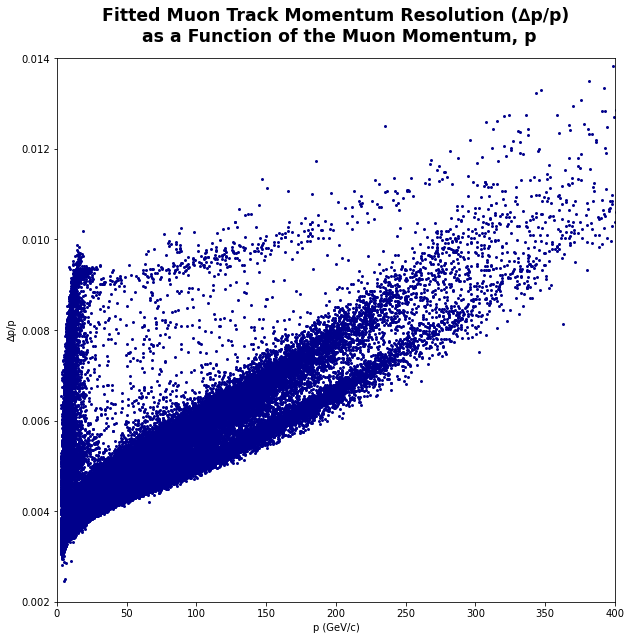

In [3]:
# Producing momentum band scatter plot
plt.scatter(data['p'], data['ep'], marker='.', linewidth=0.001, color='darkblue')
plt.xlim(0, 400)
plt.ylim(0.002, 0.014)
plt.title('Fitted Muon Track Momentum Resolution (∆p/p)\n as a Function of the Muon Momentum, p', y=1.02, weight='bold', size='xx-large')
plt.xlabel('p (GeV/c)')
plt.ylabel('∆p/p')
plt.show()

## Momentum Distribution
___

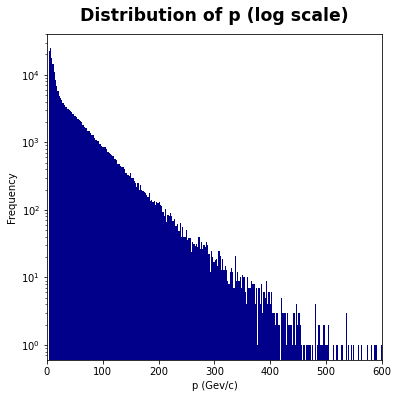

In [4]:
# Plotting the distribution of p with a log scale
plt.rcParams["figure.figsize"] = (6,6)
plt.hist(data['p'], bins=500, color='darkblue')
plt.title('Distribution of p (log scale)', y=1.02, weight='bold', size='xx-large')
plt.xlim(0, 600)
plt.xlabel('p (Gev/c)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

## Track Momentum Distribution
___

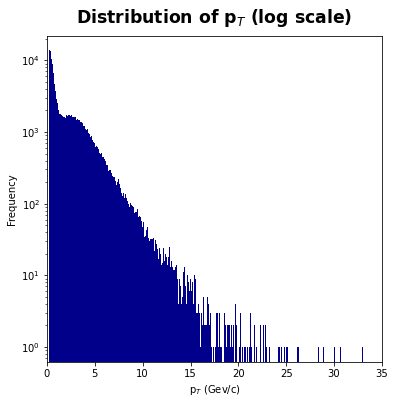

In [5]:
# Plotting the distribution of p with a log scale
plt.hist(data['pt'], bins=500, color='darkblue')
plt.title('Distribution of p$_T$ (log scale)', y=1.02, weight='bold', size='xx-large')
plt.xlim(0, 35)
plt.xlabel('p$_T$ (Gev/c)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

## Adding Variables $p_{z}$ and $\frac{\Delta_{p_{z}}}{p_{z}}$ to the Dataframe
---

From the momentum relation:

$$ p^{2} = p_{z}^{2} + p_{t}^{2}$$
$$ p_{z} ​= \sqrt{p^{2} − p_{t}^{2}}$$ 

Where: $p$ = total momentum, $p_{t}$ ​= momentum perpendicular to the z-axis, $p_{z}$ = momentum along the z-axis

​

In [6]:
new_data_1 = pd.concat([data, pd.Series(np.sqrt(data['p']**2 - data['pt']**2), name='pz')], axis=1)
new_data = pd.concat([new_data_1, pd.Series(new_data_1['ep']*new_data_1['p']/new_data_1['pz'], name='epz')], axis=1)

In [7]:
new_data

,Index,ep,eta,p,phi,pol,pt,qp,tx,ty,zV,pz,epz
0,0,0.005459,3.210803,72.079880,0.294754,1.0,5.803692,72.079880,0.077296,0.023467,-60.3975,71.845851,0.005477
1,1,0.004050,4.436362,37.638340,-0.088796,1.0,0.891071,-37.638340,0.023588,-0.002100,-60.3975,37.627791,0.004052
2,2,0.003901,3.577396,18.565832,0.319936,1.0,1.036960,18.565832,0.053102,0.017594,-60.3975,18.536851,0.003908
3,3,0.003859,3.532860,8.632520,0.219504,1.0,0.504075,-8.632520,0.057089,0.012736,-60.3975,8.617790,0.003866
4,4,0.004975,3.300828,43.359665,-0.720869,1.0,3.191501,43.359665,0.055445,-0.048714,-8.0373,43.242050,0.004989
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208979,208979,0.007196,4.140301,7.805385,0.284841,-1.0,0.248430,-7.805385,0.030561,0.008948,-10.3122,7.801430,0.007200
208980,208980,0.007210,3.852298,160.216980,2.341455,-1.0,6.800037,160.216980,-0.029593,0.030478,-47.0282,160.072609,0.007216
208981,208981,0.004592,4.234431,32.691210,1.112678,-1.0,0.947065,-32.691210,0.012818,0.025994,-47.0282,32.677489,0.004594
208982,208982,0.003816,4.122482,14.349394,2.564155,-1.0,0.464920,14.349394,-0.027161,0.017696,-47.0282,14.341860,0.003818


## Creating the $\frac{\Delta_{p_{z}}}{p_{z}}$ vs. $p_{z}$ Scatter Plot
---

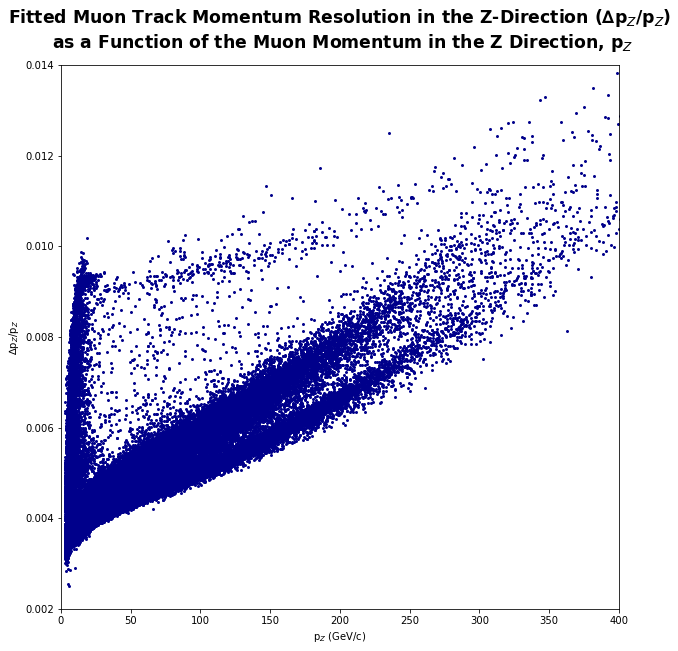

In [8]:
# Producing the momentum band scatter plot from the notes for the z direction
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(new_data['pz'], new_data['epz'], marker='.', linewidth=0.001, color='darkblue')
plt.xlim(0, 400)
plt.ylim(0.002, 0.014)
plt.title('Fitted Muon Track Momentum Resolution in the Z-Direction (∆p$_Z$/p$_Z$)\n as a Function of the Muon Momentum in the Z Direction, p$_Z$', y=1.02, weight='bold', size='xx-large')
plt.xlabel('p$_Z$ (GeV/c)')
plt.ylabel('∆p$_Z$/p$_Z$')
plt.show()

# Building a Regression Model to Predict Muon Track Momentum Resolution
---

In [9]:
# No. of inputs = 5 (p, tx, ty, eta, phi), no. of outputs = 1 (ep)
num_inputs = 5
num_outputs = 1

# Simple Keras model which uses the same no. of nodes as no. of inputs with a single layer
num_nodes = num_inputs

def simple_model():
    # Create model
    model = Sequential()
    
    # No activation required for the output as this is a regression problem
    model.add(Dense(num_nodes, input_dim=num_inputs,  kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [10]:
# Define model fitting parameters
n_epochs = 50
batch_size = 100
seed_no = 42
np.random.seed(seed_no)

# Defining the data and targets
model_data = data[['p', 'tx', 'ty', 'eta', 'phi']]
model_target = data['ep']

estimator = KerasRegressor(build_fn=simple_model, epochs=n_epochs, batch_size = batch_size)
kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results = cross_val_score(estimator, model_data, model_target, cv=kfold, scoring='r2')

2025-01-23 14:57:41.717490: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-23 14:57:41.819847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
1881/1881 [==============================] - 1s 356us/step - loss: 3.3461e-04
Epoch 2/50
1881/1881 [==============================] - 1s 343us/step - loss: 5.5031e-07
Epoch 3/50
1881/1881 [==============================] - 1s 419us/step - loss: 5.6680e-07
Epoch 4/50
1881/1881 [==============================] - 1s 365us/step - loss: 5.4658e-07
Epoch 5/50
1881/1881 [==============================] - 1s 340us/step - loss: 5.7266e-07
Epoch 6/50
1881/1881 [==============================] - 1s 337us/step - loss: 5.6329e-07
Epoch 7/50
1881/1881 [==============================] - 1s 337us/step - loss: 5.7682e-07
Epoch 8/50
1881/1881 [==============================] - 1s 349us/step - loss: 5.6884e-07
Epoch 9/50
1881/1881 [==============================] - 1s 337us/step - loss: 5.7754e-07
Epoch 10/50
1881/1881 [==============================] - 1s 339us/step - loss: 5.6638e-07
Epoch 11/50
1881/1881 [==============================] - 1s 419us/step - loss: 5.8635e-07
Epoch 12/50
1881/18

In [11]:
print("Mean:", (results.mean()))
print("Standard Deviation:", results.std ())
print(results)

Mean: 0.4587768029749464
Standard Deviation: 0.1912639863456625
[ 0.63495187  0.61516063  0.36581441  0.61134404 -0.01336712  0.58467462
  0.60875971  0.35103598  0.38599472  0.44339917]


# Evaluating Model Performance with New Estimator
---

In [12]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=simple_model, epochs = n_epochs , batch_size = batch_size)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results_new_estimator = cross_val_score(pipeline, model_data, model_target, cv=kfold, scoring='r2')

Epoch 1/50
1881/1881 [==============================] - 1s 344us/step - loss: 3.1045e-06
Epoch 2/50
1881/1881 [==============================] - 1s 341us/step - loss: 4.3917e-07
Epoch 3/50
1881/1881 [==============================] - 1s 448us/step - loss: 4.3751e-07
Epoch 4/50
1881/1881 [==============================] - 1s 350us/step - loss: 4.3804e-07
Epoch 5/50
1881/1881 [==============================] - 1s 341us/step - loss: 4.3448e-07
Epoch 6/50
1881/1881 [==============================] - 1s 341us/step - loss: 4.3741e-07
Epoch 7/50
1881/1881 [==============================] - 1s 342us/step - loss: 4.3710e-07
Epoch 8/50
1881/1881 [==============================] - 1s 342us/step - loss: 4.3741e-07
Epoch 9/50
1881/1881 [==============================] - 1s 342us/step - loss: 4.4680e-07
Epoch 10/50
1881/1881 [==============================] - 1s 341us/step - loss: 4.3758e-07
Epoch 11/50
1881/1881 [==============================] - 1s 423us/step - loss: 4.3421e-07
Epoch 12/50
1881/18

In [13]:
print("Mean:", (results_new_estimator.mean()))
print("Standard Deviation:", results_new_estimator.std ())
print(results)

Mean: 0.7187647375247869
Standard Deviation: 0.014406214152681137
[ 0.63495187  0.61516063  0.36581441  0.61134404 -0.01336712  0.58467462
  0.60875971  0.35103598  0.38599472  0.44339917]


# Evaluating Denser Model
---

In [14]:
def denser_model():
    # Create model
    model = Sequential()
    
    # No activation required for the output as this is a regression problem
    model.add(Dense(num_nodes, input_dim=num_inputs,  kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [15]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=denser_model, epochs=n_epochs , batch_size=batch_size)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results_denser = cross_val_score(pipeline, model_data, model_target, cv=kfold, scoring='r2')

Epoch 1/50
1881/1881 [==============================] - 1s 442us/step - loss: 7.0461e-07
Epoch 2/50
1881/1881 [==============================] - 1s 374us/step - loss: 4.3927e-07
Epoch 3/50
1881/1881 [==============================] - 1s 368us/step - loss: 4.4560e-07
Epoch 4/50
1881/1881 [==============================] - 1s 366us/step - loss: 4.3448e-07
Epoch 5/50
1881/1881 [==============================] - 1s 367us/step - loss: 4.3435e-07
Epoch 6/50
1881/1881 [==============================] - 1s 367us/step - loss: 4.3194e-07
Epoch 7/50
1881/1881 [==============================] - 1s 367us/step - loss: 4.3969e-07
Epoch 8/50
1881/1881 [==============================] - 1s 368us/step - loss: 4.3646e-07
Epoch 9/50
1881/1881 [==============================] - 1s 465us/step - loss: 4.2912e-07
Epoch 10/50
1881/1881 [==============================] - 1s 377us/step - loss: 4.3598e-07
Epoch 11/50
1881/1881 [==============================] - 1s 367us/step - loss: 4.3809e-07
Epoch 12/50
1881/18

In [16]:
print("Mean:", (results_denser.mean()))
print("Standard Deviation:", results_denser.std ())
print(results)

Mean: 0.7195776347712991
Standard Deviation: 0.024916774089725324
[ 0.63495187  0.61516063  0.36581441  0.61134404 -0.01336712  0.58467462
  0.60875971  0.35103598  0.38599472  0.44339917]


# Evaluating Wider Model
---

In [17]:
def wider_model():
    # Create model
    model = Sequential()
    
    # No activation required for the output as this is a regression problem
    model.add(Dense(num_inputs*2, input_dim=num_inputs,  kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [18]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=n_epochs , batch_size=batch_size)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results_wider = cross_val_score(pipeline, model_data, model_target, cv=kfold, scoring='r2')

Epoch 1/50
1881/1881 [==============================] - 1s 505us/step - loss: 2.3812e-06
Epoch 2/50
1881/1881 [==============================] - 1s 369us/step - loss: 3.7237e-07
Epoch 3/50
1881/1881 [==============================] - 1s 374us/step - loss: 3.5124e-07
Epoch 4/50
1881/1881 [==============================] - 1s 362us/step - loss: 3.4261e-07
Epoch 5/50
1881/1881 [==============================] - 1s 357us/step - loss: 3.4176e-07
Epoch 6/50
1881/1881 [==============================] - 1s 358us/step - loss: 3.4583e-07
Epoch 7/50
1881/1881 [==============================] - 1s 417us/step - loss: 3.4468e-07
Epoch 8/50
1881/1881 [==============================] - 1s 394us/step - loss: 3.4398e-07
Epoch 9/50
1881/1881 [==============================] - 1s 357us/step - loss: 3.4576e-07
Epoch 10/50
1881/1881 [==============================] - 1s 360us/step - loss: 3.4462e-07
Epoch 11/50
1881/1881 [==============================] - 1s 358us/step - loss: 3.4201e-07
Epoch 12/50
1881/18

In [19]:
print("Mean:", (results_wider.mean()))
print("Standard Deviation:", results_wider.std ())
print(results)

Mean: 0.7303624958779474
Standard Deviation: 0.03094536009489998
[ 0.63495187  0.61516063  0.36581441  0.61134404 -0.01336712  0.58467462
  0.60875971  0.35103598  0.38599472  0.44339917]


### Model Comparison

The wider model improves the R squared score the most. Changing the estimator to a pipeline almost doubles the R squared.

## Final Model
---

In [20]:
def model_5():
    # Create model
    model = Sequential()
    
    # No activation required for the output as this is a regression problem
    model.add(Dense(num_inputs*8, input_dim=num_inputs,  kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_inputs, kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs, kernel_initializer='normal'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [21]:
# No. of inputs = 5 (p, tx, ty, eta, phi), no. of outputs = 1 (ep)
num_inputs = 5
num_outputs = 1

# Simple Keras model which uses the same no. of nodes as no. of inputs with a single layer
num_nodes = num_inputs

# Define model fitting parameters
seed_no = 42
np.random.seed(seed_no)

# Defining the data and targets
model_data = data[['p', 'tx', 'ty', 'eta', 'phi']]
model_target = data['ep']

In [22]:
n_epochs = 50
batch_size = 50

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=model_5, epochs=n_epochs , batch_size=batch_size)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10, random_state=seed_no, shuffle = True)

# Data and target are 5 - column and 1 - column arrays produced with pandas.DataFrame.values
results_5 = cross_val_score(pipeline, model_data, model_target, cv=kfold, scoring='r2')

Epoch 1/50
3762/3762 [==============================] - 2s 383us/step - loss: 8.0024e-07
Epoch 2/50
3762/3762 [==============================] - 2s 429us/step - loss: 3.6713e-07
Epoch 3/50
3762/3762 [==============================] - 1s 378us/step - loss: 3.4130e-07
Epoch 4/50
3762/3762 [==============================] - 1s 377us/step - loss: 3.3884e-07
Epoch 5/50
3762/3762 [==============================] - 1s 398us/step - loss: 3.3317e-07
Epoch 6/50
3762/3762 [==============================] - 2s 402us/step - loss: 3.3845e-07
Epoch 7/50
3762/3762 [==============================] - 1s 378us/step - loss: 3.2882e-07
Epoch 8/50
3762/3762 [==============================] - 1s 381us/step - loss: 3.2258e-07
Epoch 9/50
3762/3762 [==============================] - 2s 442us/step - loss: 3.2956e-07
Epoch 10/50
3762/3762 [==============================] - 1s 377us/step - loss: 3.3368e-07
Epoch 11/50
3762/3762 [==============================] - 1s 378us/step - loss: 3.3334e-07
Epoch 12/50
3762/37

In [23]:
print("Mean:", (results_5.mean()))
print("Standard Deviation:", results_5.std ())
print(results_5)

Mean: 0.7344999308698086
Standard Deviation: 0.04316480789662083
[0.78557313 0.79558219 0.73694402 0.72644997 0.79925849 0.68634982
 0.71195351 0.69764599 0.73270879 0.6725334 ]


In [24]:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(pipeline, model_data, model_target, cv=kfold)

Epoch 1/50
3762/3762 [==============================] - 2s 381us/step - loss: 7.9904e-07
Epoch 2/50
3762/3762 [==============================] - 2s 454us/step - loss: 3.5765e-07
Epoch 3/50
3762/3762 [==============================] - 1s 379us/step - loss: 3.5370e-07
Epoch 4/50
3762/3762 [==============================] - 1s 376us/step - loss: 3.4024e-07
Epoch 5/50
3762/3762 [==============================] - 1s 387us/step - loss: 3.3282e-07
Epoch 6/50
3762/3762 [==============================] - 2s 431us/step - loss: 3.3389e-07
Epoch 7/50
3762/3762 [==============================] - 1s 377us/step - loss: 3.2827e-07
Epoch 8/50
3762/3762 [==============================] - 1s 376us/step - loss: 3.3439e-07
Epoch 9/50
3762/3762 [==============================] - 2s 414us/step - loss: 3.3529e-07
Epoch 10/50
3762/3762 [==============================] - 1s 376us/step - loss: 3.3226e-07
Epoch 11/50
3762/3762 [==============================] - 1s 374us/step - loss: 3.3011e-07
Epoch 12/50
3762/37

# Analysis of Predicted Values
---

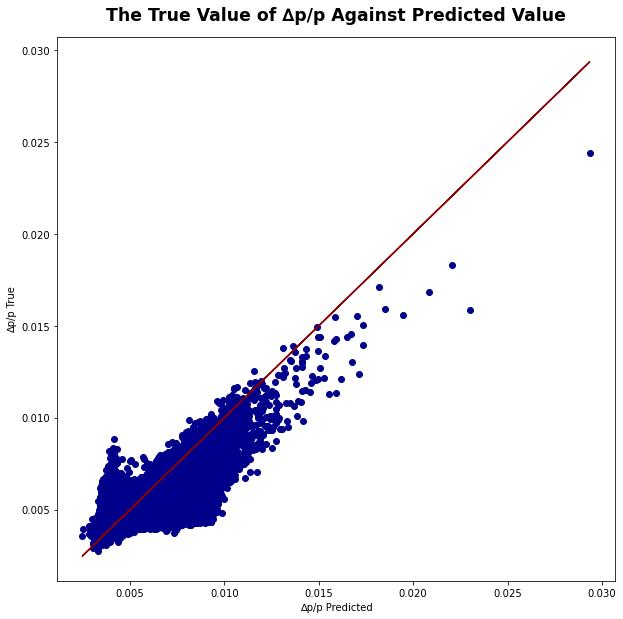

In [25]:
# Plotting scatter of predicted and true values
plt.scatter(model_target, predicted, color='darkblue')
plt.title('The True Value of ∆p/p Against Predicted Value', y=1.02, weight='bold', size='xx-large')
plt.xlabel('∆p/p Predicted')
plt.ylabel('∆p/p True')
# Overlaying y = x line
plt.plot(model_target, model_target, color='darkred')
plt.show()

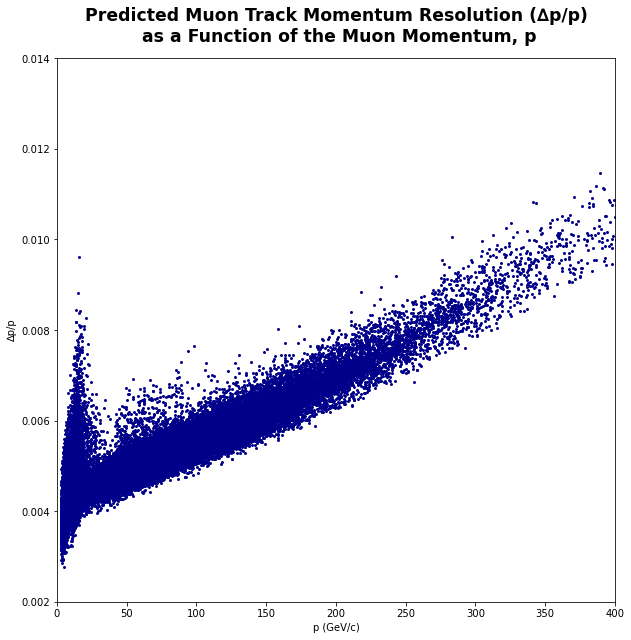

In [26]:
# Producing the momentum band scatter plot from predicted values
plt.scatter(data['p'], predicted, marker='.', linewidth=0.001, color='darkblue')
plt.xlim(0, 400)
plt.ylim(0.002, 0.014)
plt.title('Predicted Muon Track Momentum Resolution (∆p/p)\n as a Function of the Muon Momentum, p', y=1.02, weight='bold', size='xx-large')
plt.xlabel('p (GeV/c)')
plt.ylabel('∆p/p')
plt.show()